In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-ivp-implicit)=
# Implementation of multistep methods

```{index} multistep method; implementation of
```

We now consider some of the practical issues that arise when multistep formulas are used to solve IVPs. In this section we emphasize the vector IVP, $\mathbf{u}'=\mathbf{f}(t,\mathbf{u})$, and use boldface in the difference formula {eq}`multistep` as well. 

## Explicit methods

As a concrete example, the AB4 method is defined by the formula

```{math}
:label: ab4
\mathbf{u}_{i+1} = \mathbf{u}_i + h\, ( \tfrac{55}{24}\mathbf{f}_i - \tfrac{59}{24} \mathbf{f}_{i-1} + \tfrac{37}{24}\mathbf{f}_{i-2} - \tfrac{9}{24}\mathbf{f}_{i-3}), \quad i=3,\ldots,n-1.
```

{numref}`Function {number} <function-ab4>` shows a basic implementation of AB4. 

Observe that {numref}`Function {number} <function-rk4>` is used to find the starting values $\mathbf{u}_1,\mathbf{u}_2,\mathbf{u}_3$ that are needed before the iteration formula takes over. As far as RK4 is concerned, it needs to solve  (the same step size as in the AB4 iteration). These results are then used to find $\mathbf{f}_0,\ldots,\mathbf{f}_3$ and get the main iteration started.

(function-ab4)=
````{proof:function} ab4
**4th-order Adams–Bashforth formula for an IVP**

```{code-block} julia1
:lineno-start: 1
"""
    ab4(ivp,n)

Apply the Adams-Bashforth 4th order method to solve the given IVP
using `n` time steps. Returns a vector of times and a vector of
solution values.
"""
function ab4(ivp,n) 
    # Time discretization.
    a,b = ivp.tspan
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]

    # Constants in the AB4 method.
    k = 4;   σ = [55,-59,37,-9]/24;

    # Find starting values by RK4.
    u = fill(float(ivp.u0),n+1)
    rkivp = ODEProblem(ivp.f,ivp.u0,(a,a+(k-1)*h),ivp.p)
    ts,us = rk4(rkivp,k-1)
    u[1:k] .= us

    # Compute history of u' values, from newest to oldest.
    f = [ ivp.f(u[k-i],ivp.p,t[k-i]) for i in 1:k-1  ]

    # Time stepping.
    for i in k:n
        f = [ ivp.f(u[i],ivp.p,t[i]), f[1:k-1]... ]   # new value of du/dt
        u[i+1] = u[i] + h*sum(f[j]*σ[j] for j in 1:k)  # advance a step
    end
    return t,u
end
```
````

::::{admonition} About the code
:class: dropdown
Line 15 sets `σ` to be the coefficients of the generating polynomial $\sigma(z)$ of AB4. Lines 19--21 set up the IVP over the time interval $a \le t \le a+3 h$, call `rk4` to solve it using the step size $h$, and use the result to fill the first four values of the solution. Then line 24 computes the vector $[f_2,f_1,f_0]$. 

Line 28 computes $f_i$, based on the most recent solution value and time. That goes into the first spot of `f`, followed by the three values that were previously most recent. These are the four values that appear in {eq}`ab4`. Each particular $f_i$ value starts at the front of `f`, moves through each position in the vector over three iterations, and then is forgotten.
::::


(demo-implicit-ab4)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

We study the convergence of AB4 using the IVP $u'=\sin[(u+t)^2]$ over $0\le t \le 4$, with $u(0)=-1$. As usual, `solve` is called to give an accurate reference solution.

In [2]:
ivp = ODEProblem((u,p,t)->sin((t+u)^2),-1.,(0.0,4.0))
u_ref = solve(ivp,Tsit5(),reltol=1e-14,abstol=1e-14);

Now we perform a convergence study of the AB4 code.

In [3]:
n = @. [ round(Int,4*10^k) for k in 0:0.5:3 ]
err = []
for n in n
    t,u = FNC.ab4(ivp,n)
    push!( err, norm(u_ref.(t)-u,Inf) )
end

pretty_table([n err],["n","inf-norm error"])

┌──────┬────────────────┐
│    n │ inf-norm error │
├──────┼────────────────┤
│    4 │        0.50044 │
│   13 │        1.39129 │
│   40 │     0.00627809 │
│  126 │     9.94942e-5 │
│  400 │     1.09598e-6 │
│ 1265 │     1.12766e-8 │
│ 4000 │    1.13736e-10 │
└──────┴────────────────┘


The method should converge as $O(h^4)$, so a log-log scale is appropriate for the errors.

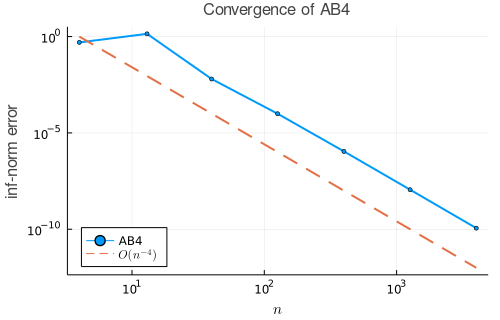

In [4]:
plot(n,err,m=3,label="AB4",
    xaxis=(:log10,L"n"),yaxis=(:log10,"inf-norm error"),
    title="Convergence of AB4",leg=:bottomleft)

plot!(n,(n/n[1]).^(-4),l=:dash,label=L"O(n^{-4})")

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

## Implicit methods

```{index} implicit IVP solver
```

The implementation of an implicit multistep method is more difficult. Consider the second-order implicit formula AM2, also known as the trapezoid method. To advance from step $i$ to $i+1$, we need to solve

```{math}
  :label: AM2solve
  \mathbf{z} - \tfrac{1}{2} h f(t_{i+1},\mathbf{z})  = \mathbf{u}_i + \tfrac{1}{2} h \mathbf{f}(t_i,\mathbf{u}_i)
```

for $\mathbf{z}$. This equation can be written as $\mathbf{g}(\mathbf{z})=\boldsymbol{0}$, so the rootfinding methods of Chapter 4 can be used. The new value $\mathbf{u}_{i+1}$ is equal to the root of this equation.  

An implementation of AM2 using {numref}`Function {number} <function-levenberg>` from {numref}`section-nonlineqn-quasinewton` is shown in {numref}`Function {number} <function-am2>`. 

(function-am2)=
````{proof:function} am2
**2nd-order Adams–Moulton (trapezoid) formula for an IVP**

```{code-block} julia1
:lineno-start: 1
"""
    am2(ivp,n)

Apply the Adams-Moulton 2nd order method to solve given IVP using
`n` time steps. Returns a vector of times and a vector of
solution values.
"""
function am2(ivp,n)
    # Time discretization.
    a,b = ivp.tspan
    h = (b-a)/n
    t = [ a + i*h for i in 0:n ]

    # Initialize output.
    u = fill(float(ivp.u0),n+1)

    # Time stepping.
    for i in 1:n
        # Data that does not depend on the new value.
        known = u[i] + h/2*ivp.f(u[i],ivp.p,t[i])
        # Find a root for the new value.
        g = z -> z - h/2*ivp.f(z,ivp.p,t[i+1]) - known
        unew = levenberg(g,known)
        u[i+1] = unew[end]
    end
    return t,u
end
```
````

::::{admonition} About the code
:class: dropdown
Lines 22-23 define the function $\mathbf{g}$ and call `levenberg` to find the new solution value, using an Euler half-step as its starting value. A robust code would have to intercept the case where `levenberg` fails to converge, but we have ignored this issue for the sake of brevity.
::::

## Stiff problems

At each time step in {numref}`Function {number} <function-am2>`, or any implicit IVP solver, a rootfinding iteration of uncertain expense is needed, requiring multiple calls to evaluate the function $\mathbf{f}$. This fact makes the cost of an implicit method much greater on a per-step basis than for an explicit one. Given this drawback, you are justified to wonder whether implicit methods are ever competitive! The answer is emphatically yes, as {numref}`Demo %s <demo-implicit-stiff>` demonstrates.

```{index} stiff differential equation
```

(demo-implicit-stiff)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

The following simple ODE uncovers a surprise.

In [5]:
ivp = ODEProblem((u,p,t)->u^2-u^3, 0.005, (0,400.))

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 400.0)
u0: 0.005

We will solve the problem first with the implicit AM2 method using $n=200$ steps.

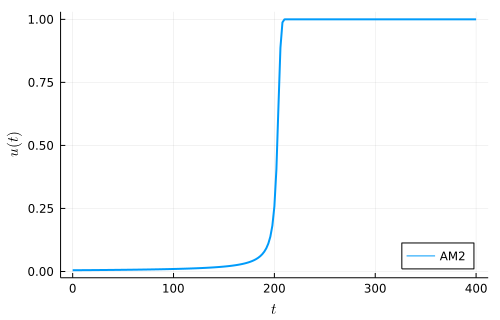

In [6]:
tI,uI = FNC.am2(ivp,200)

plot(tI,uI,label="AM2",
    xlabel=L"t",ylabel=L"u(t)",leg=:bottomright)

Now we repeat the process using the explicit AB4 method.

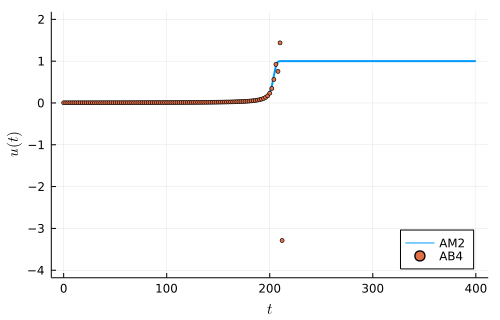

In [7]:
tE,uE = FNC.ab4(ivp,200)

scatter!(tE,uE,m=3,label="AB4",ylim=[-4,2])

Once the solution starts to take off, the AB4 result goes catastrophically wrong.

In [8]:
uE[105:111]

7-element Vector{Float64}:
   0.7553857798343923
   1.4372970308402562
  -3.2889768512289934
 214.1791132643978
  -4.482089146771584e7
   4.1268902909420876e23
  -3.221441244795439e71

We hope that AB4 will converge in the limit $h\to 0$, so let's try using more steps.

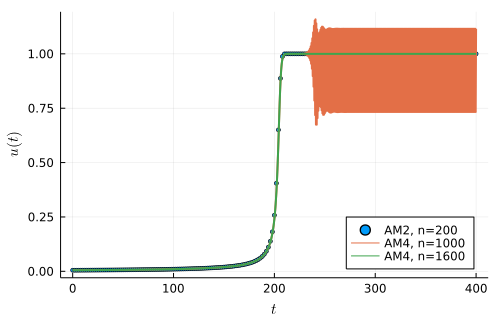

In [9]:
plt = scatter(tI,uI,label="AM2, n=200",m=3,
    xlabel=L"t",ylabel=L"u(t)",leg=:bottomright)

for n in [1000,1600]
    tE,uE = FNC.ab4(ivp,n)
    plot!(tE,uE,label="AM4, n=$n")
end
plt

So AB4, which is supposed to be _more_ accurate than AM2, actually needs something like 8 times as many steps to get a reasonable-looking answer!
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

Although the result of {numref}`Demo %s <demo-implicit-stiff>` may seem counter-intuitive, there is no contradiction. A fourth-order explicit formula is more accurate than a second-order implicit one, in the limit $h\to 0$. But there is another limit to consider, $t\to \infty$ with $h$ fixed, and in this one the implicit method wins. 

Problems for which implicit methods are much more efficient than explicit counterparts are called **stiff**. A complete mathematical description will wait for Chapter 11, but a sure sign of stiffness is the presence of phenomena on widely different time scales. In {numref}`Demo {number} <demo-implicit-stiff>`, for instance, there are two slow periods during which the solution changes very little, interrupted by a very fast transition in the state. An explicit method "thinks" that the step size must always be dictated by the time scale of the fast transition, whereas an implicit method can take large steps during the slow periods.

```{index} adaptivity; in IVP solver
```

## Adaptivity

As with RK methods, we can run two time stepping methods simultaneously in order to estimate the error and adjust the step size. For example, we could pair AB3 with AB4 as practically no cost because the methods differ only in how they include known information from the recent past. The more accurate AB4 value should allow an accurate estimate of the local error in the AB3 value, and so on.

Because multistep methods rely on the solution history, though, changing the step size is more algebraically complicated than for RK methods. If $h$ is changed, then the historical values $\mathbf{u}_{i-1},\mathbf{u}_{i-2}\ldots$ and $\mathbf{f}_{i-1},\mathbf{f}_{i-2}\ldots$ are no longer given at the right moments in time to apply the iteration formula. A typical remedy is to use interpolation to re-evaluate the historical values at the appropriate times. The details are important but not especially illuminating, and we do not give them here.

## Exercises

% Must stay as #1
(problem-implicit-ab4tests)=

1. ⌨ For each IVP, solve the problem using {numref}`Function {number} <function-ab4>` with $n=100$, and plot the solution and the error $u-\hat{u}$ on separate plots.

    **(a)** $u' = -2t u, \ 0 \le t \le 2, \ u(0) = 2;\  \hat{u}(t) = 2e^{-t^2}$

    **(b)** $u' = u + t, \ 0 \le t \le 1, \ u(0) = 2;\  \hat{u}(t) = 1-t+e^t$

    **(c)** $u' = x^2/[u(1+x^3)],\ 0 \le x \le 3, \ u(0) =1;\ \hat{u}(x) =[1+(2/3)\ln (1+x^3)]^{1/2}$

    **(d)** $u''+ 9u = 9t, \: 0< t< 2\pi, \: u(0) =1,\: u'(0) = 1; \: \hat{u}(t) = t+\cos (3t)$

    **(e)** $u''+ 9u = \sin(2t), \: 0< t< 2\pi, \: u(0) =2,\: u'(0) = 1$;
    $\quad \hat{u}(t) = (1/5) \sin(3t) + 2 \cos (3t)+ (1/5) \sin (2t)$

    **(f)** $u''- 9u = 9t \: 0< t< 1, \: u(0) =2,\: u'(0) = -1; \: \hat{u}(t) = e^{3t} + e^{-3t}-t$

    **(g)** $u''+ 4u'+ 4u = t, \: 0< t< 4, \: u(0) =1,\: u'(0) = 3/4; \: \hat{u}(t) = (3t+5/4)e^{-2t} + (t-1)/4$

    **(h)** $x^2 u'' +5xu' + 4u = 0,\: 1<x<e^2, \: u(1) =1, \: u'(1) = -1; \: \hat{u}(x) = x^{-2}( 1 + \ln x)$

    **(i)** $2 x^2 u'' +3xu' - u = 0,\: 1<x<16, \: u(1) =4, \: u'(1) = -1$;
    $\quad \hat{u}(x) = 2(x^{1/2} + x^{-1})$

    **(j)** $x^2 u'' -xu' + 2u = 0,\: 1<x<e^{\pi}, \: u(1) =3, \: u'(1) = 4$;
    $\quad \hat{u}(x) = x \left[ 3 \cos \left( \ln x \right)+\sin \left( \ln x \right) \right]$

    (problem-implicit-ab4converge)=
2. ⌨ For each IVP in Exercise 1, use {numref}`Function {number} <function-ab4>` for $n=10\cdot2^d$ and $d=1,\ldots,10$. Make a log-log convergence plot for the final time error $|u_n-\hat{u}(t_n)|$ versus $n$, and add a straight line indicating fourth-order convergence.

3. ⌨ Repeat Exercise 1 above  using {numref}`Function {number} <function-am2>`.

4. ⌨  Repeat Exercise 2 above using {numref}`Function {number} <function-am2>` and comparing to second-order rather than fourth-order convergence.

5. ⌨ Using {numref}`Function {number} <function-am2>` as a model, write a function `bd2` that applies the BD2 method to solve an IVP. Test the convergence of your function on one of the IVPs in [Exercise 1](problem-implicit-ab4tests) above.

6. ⌨ For double-precision purposes, the exact solution of the IVP in {numref}`Demo %s <demo-implicit-stiff>` satisfies $\hat{u}(400)=1$.

    **(a)** Use {numref}`Function {number} <function-ab4>` with $n=600,800,1000,\ldots,2000$ and make a log-log convergence plot of the error $|u_n-1|$ as a function of $n$.

    **(b)** Repeat part (a) using {numref}`Function {number} <function-am2>`.

    (problem-implicit-ivpimag)=
7. Consider the IVP
  
    ```{math}
    \mathbf{u}'(t) = \mathbf{A} \mathbf{u}(t), \quad \mathbf{A}=
    \begin{bmatrix}
      0&-4\\4&0
    \end{bmatrix}, \quad \mathbf{u}(0) =
    \begin{bmatrix}
      1\\0
    \end{bmatrix}.
    ```

    **(a)** ✍ Define $E(t) = \bigl\|\mathbf{u}(t)\bigr\|_2^2$. Show that $E(t)$ is constant. (Hint: differentiate $\mathbf{u}^T\mathbf{u}$ with respect to time and simplify it.)

    **(b)** ⌨ Use {numref}`Function {number} <function-ab4>` to solve the IVP for $t\in[0,20]$ with $n=100$ and $n=150$. Plot $|E(t)-E(0)|$ versus time for both solutions on a single log-linear graph. You should see exponential growth in time. (In this regime, AB4 is acting unstably in a sense discussed in {numref}`section-diffusion-absstab`.)

    **(c)** ⌨ Repeat part (b) with $n=400$ and $n=600$, but on a linear-linear plot. Now you should see only linear growth of $|E(t)-E(0)|$. (In this regime, AB4 is fully stable.)

    **(d)** ⌨ Repeat part (b) with AM2 instead of AB4, on a linear-linear plot. You will find that AM2 conserves energy, just like the exact solution. 
  
8. ⌨ **(a)** Modify {numref}`Function {number} <function-ab4>` to implement the AB2 method.

    **(b)** Repeat part (b) of the preceding exercise, using AB2 in place of AB4.

    **(c)** Repeat part (c) of the preceding exercise, using AB2 in place of AB4.
  
9. ⌨ **(a)** Modify {numref}`Function {number} <function-am2>` to implement the backward Euler (AM1) method.

    **(b)** Repeat part (d) of Exercise 7 above, using AM1 in place of AM2 and $n=400,800$. Does the AM1 method conserve energy?